# Energy Histrogram

In [16]:
import zntrack
import matplotlib.pyplot as plt
import numpy as np
import imageio
import tempfile

In [4]:
nodes = [zntrack.from_rev(f"ML{idx}_EnergyHistogram") for idx in range(8)]

energies = []
for node in nodes:
    energies.append([x.get_potential_energy() for x in node.data])

with imageio.get_writer('histogram.gif', mode='I', duration=1000) as writer:
    for idx, data in enumerate(energies):
        fig, ax = plt.subplots()
        # ax.hist(data, density=True, bins=20, alpha=0.5, label=idx)
        data = np.histogram(data, density=True, bins=50 if idx == 0 else 100)
        ax.plot(data[1][:-1], data[0], label=idx)
        ax.set_xlim(np.min(sum(energies, [])), np.max(sum(energies, [])))
        ax.set_xlabel(r"Energy  E / eV")
        ax.set_ylabel(r"Probability density")
        ax.set_title(f"# training points: {len(nodes[idx].data)}")
        with tempfile.TemporaryFile() as fp:
            fig.savefig(fp)
            writer.append_data(imageio.imread(fp))

In [25]:
nodes = [zntrack.from_rev(f"ML{idx}_ASEMD") for idx in range(2, 9)]

energies = []
for node in nodes:
    energies.append([x.get_potential_energy() for x in node.atoms])

/tmp/ipykernel_2226053/4219085410.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(fp))


/tmp/ipykernel_2226053/4219085410.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(fp))


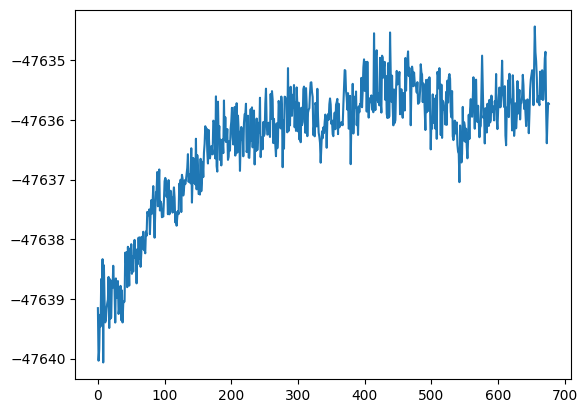

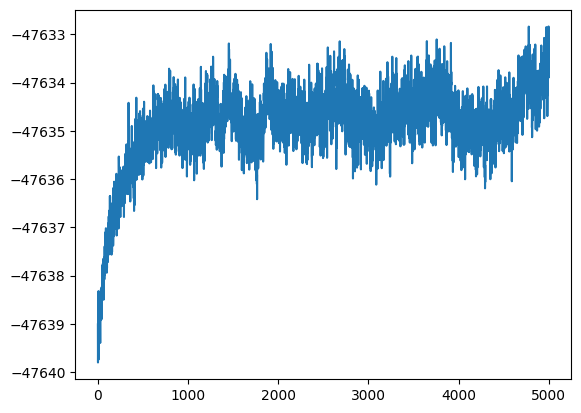

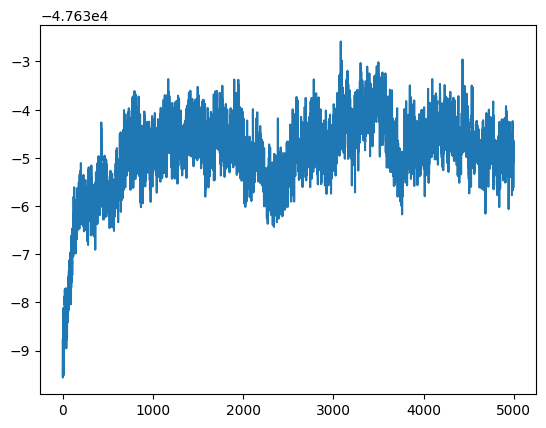

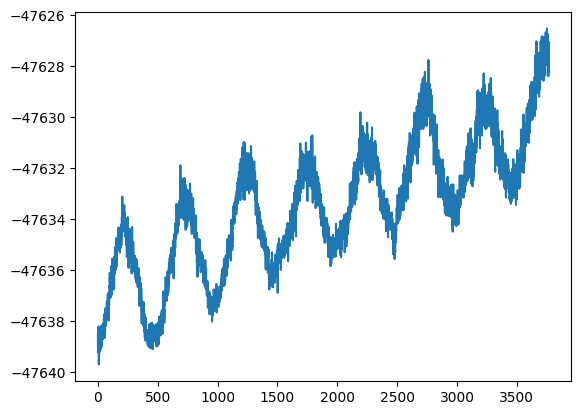

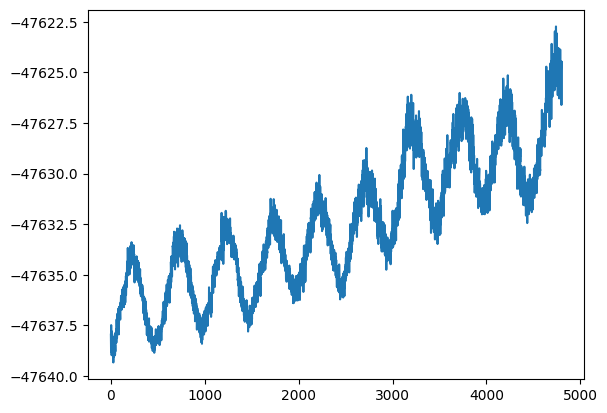

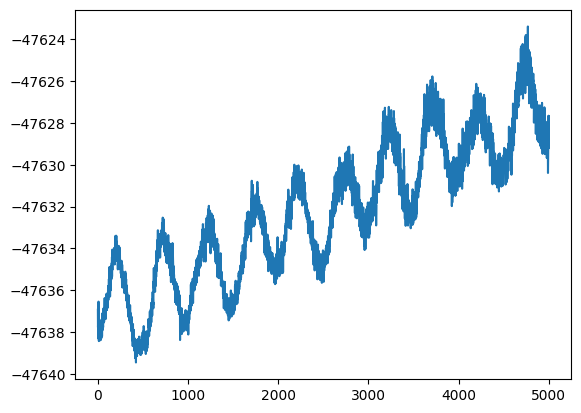

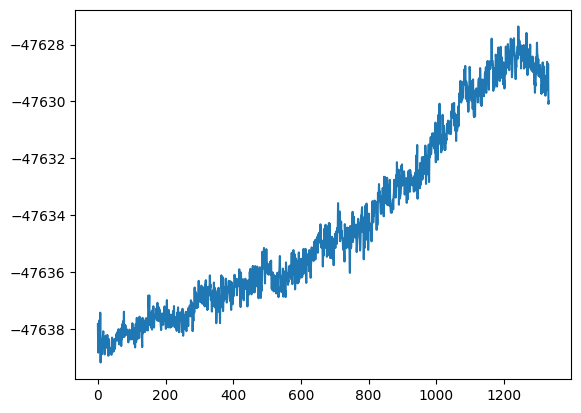

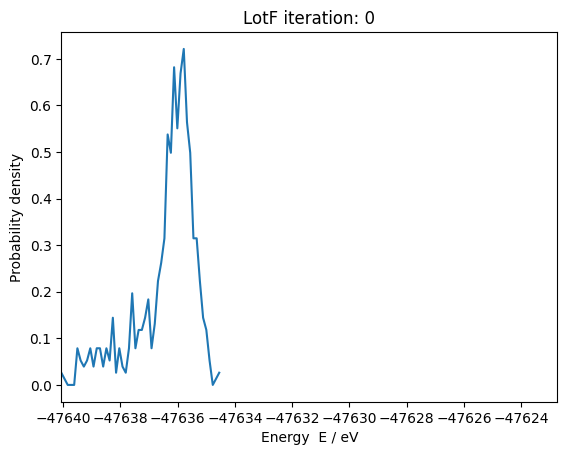

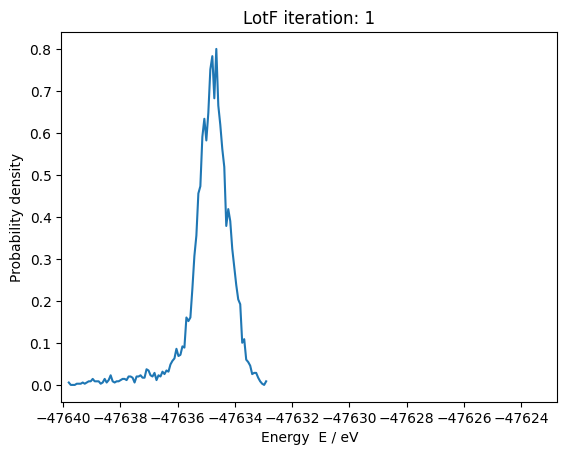

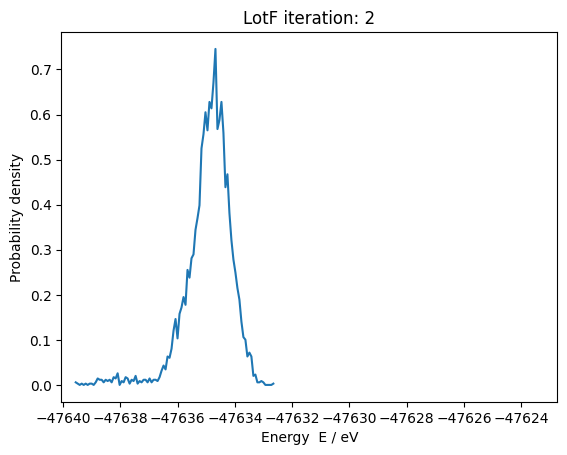

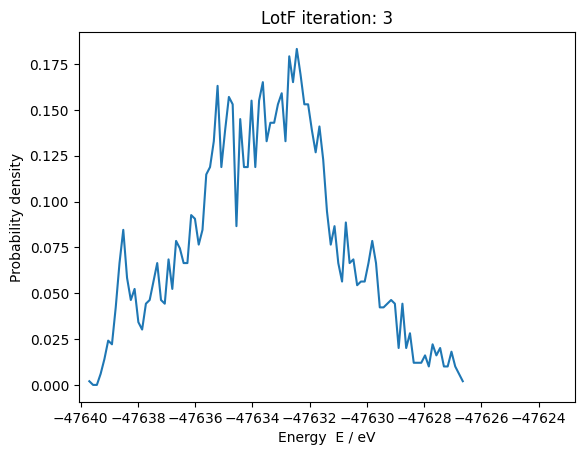

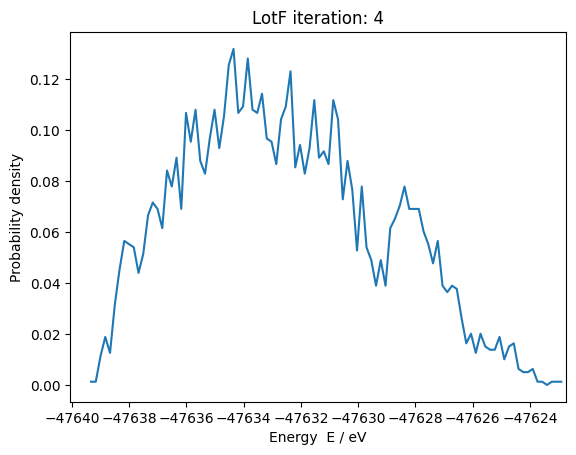

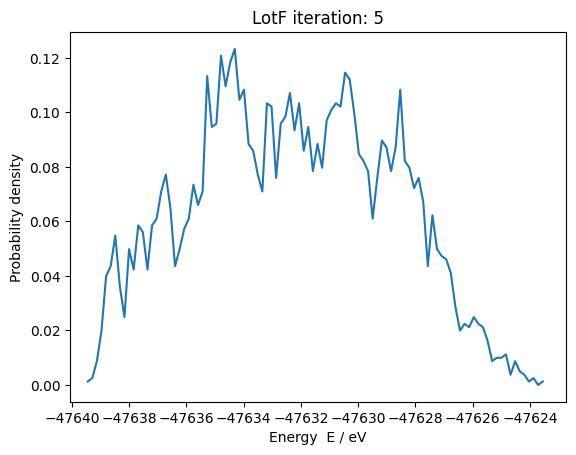

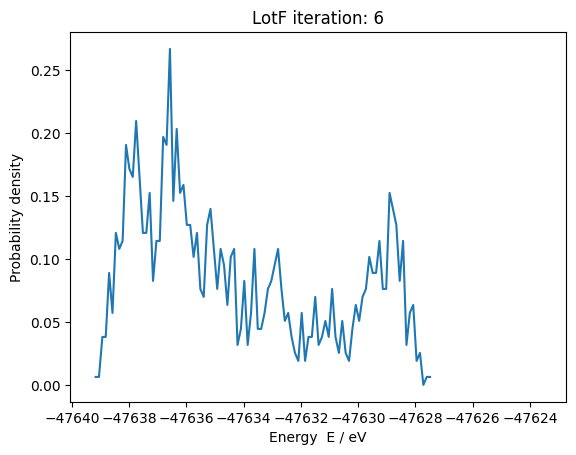

In [26]:
with imageio.get_writer('md_energy.gif', mode='I', duration=1000) as writer:
    for idx, data in enumerate(energies):
        fig, ax = plt.subplots()
        # ax.hist(data, density=True, bins=20, alpha=0.5, label=idx)
        ax.plot(data)
        ax.set_xlabel(r"Time  t / 10 fs")
        ax.set_ylabel(r"Energy  E / eV")
        with tempfile.TemporaryFile() as fp:
            fig.savefig(fp)
            writer.append_data(imageio.imread(fp))

with imageio.get_writer('md_histogram.gif', mode='I', duration=1000) as writer:
    for idx, data in enumerate(energies):
        fig, ax = plt.subplots()
        # ax.hist(data, density=True, bins=20, alpha=0.5, label=idx)
        data = np.histogram(data, density=True, bins=50 if idx == 0 else 100)
        ax.plot(data[1][:-1], data[0], label=idx)
        ax.set_xlim(np.min(sum(energies, [])), np.max(sum(energies, [])))
        ax.set_xlabel(r"Energy  E / eV")
        ax.set_ylabel(r"Probability density")
        ax.set_title(f"LotF iteration: {idx}")
        with tempfile.TemporaryFile() as fp:
            fig.savefig(fp)
            writer.append_data(imageio.imread(fp))

In [1]:
import dvc.api

In [2]:
exps = dvc.api.exp_show()

In [3]:
import zntrack
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
data = {}
# for exp in [
#     "sewed-ages",
#     "store-bate",
#     "mauve-muss",
#     "staid-sand",
#     "eerie-mesh",
#     "yummy-owls",
#     "curst-mete",
#     "quasi-zack",
#     "weird-wire",
#     "tasty-koas",
#     "blond-fuss",
#     "glial-math",
#     "mirky-doxy",
#     "nasty-wens",
#     "finny-nosh",
#     "aided-weir",
# ]:
for exp in [x["Experiment"]  for x in exps if x["Experiment"] is not None]:
    data[exp] = zntrack.get_nodes(rev=exp)

2023-11-12 13:21:53,019 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


In [5]:
n_ml0 = []
md_steps = []
n_ml1 = []
forces_rmse = []
forces_max = []
energy_rmse = []
energy_max = []
for exp in data:
    n_ml0.append(data[exp]["classical_ConfigurationSelection_2"].n_configurations)
    n_ml1.append(data[exp]["ML0_ConfigurationSelection"].n_configurations)
    md_steps.append(data[exp]["ML0_ASEMD"].steps_before_stopping)
    forces_rmse.append(data[exp]["ML0_PredictionMetrics"].forces["rmse"])
    forces_max.append(data[exp]["ML0_PredictionMetrics"].forces["max"])
    energy_rmse.append(data[exp]["ML0_PredictionMetrics"].energy["rmse"])
    energy_max.append(data[exp]["ML0_PredictionMetrics"].energy["max"])

md_steps = [x if x != -1 else 50000 for x in md_steps]

df = pd.DataFrame(
    {
        "n_ml0": n_ml0,
        "n_ml1": n_ml1,
        "md_steps": md_steps,
        "forces_rmse": forces_rmse,
        "forces_max": forces_max,
        "energy_rmse": energy_rmse,
        "energy_max": energy_max,
    }
)
df.to_csv("analysis.csv")

Text(0, 0.5, '# MD steps before uncertainty threshold is exceeded')

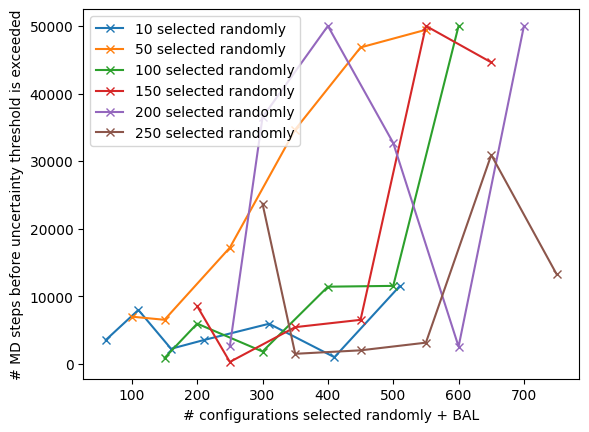

In [6]:
# group the dataframe by n_ml0 and plot the scatter plot of n_ml1 vs md_steps in a single plot
fig, ax = plt.subplots()
for label, _df in df.groupby("n_ml0"):
    _df = _df.sort_values("n_ml1")
    ax.plot(
        _df["n_ml1"] + label,
        _df["md_steps"],
        marker="x",
        label=f"{label} selected randomly",
    )
ax.legend()
ax.set_xlabel("# configurations selected randomly + BAL")
ax.set_ylabel("# MD steps before uncertainty threshold is exceeded")

Text(0, 0.5, 'energy max / $\\mathrm{meV}$ / atom')

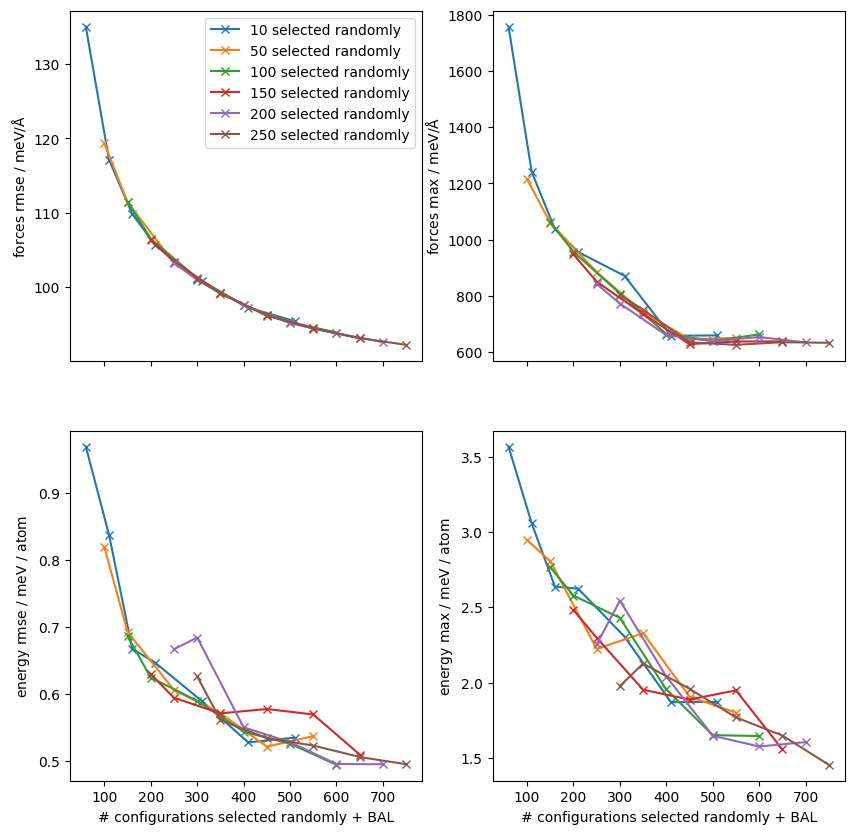

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
for label, _df in df.groupby("n_ml0"):
    _df = _df.sort_values("n_ml1")
    ax[0][0].plot(
        _df["n_ml1"] + label,
        _df["forces_rmse"],
        marker="x",
        label=f"{label} selected randomly",
    )
    ax[0][1].plot(
        _df["n_ml1"] + label,
        _df["forces_max"],
        marker="x",
        label=f"{label} selected randomly",
    )
    ax[1][0].plot(
        _df["n_ml1"] + label,
        _df["energy_rmse"],
        marker="x",
        label=f"{label} selected randomly",
    )
    ax[1][1].plot(
        _df["n_ml1"] + label,
        _df["energy_max"],
        marker="x",
        label=f"{label} selected randomly",
    )

ax[0][0].legend()

ax[1][0].set_xlabel("# configurations selected randomly + BAL")
ax[1][1].set_xlabel("# configurations selected randomly + BAL")
ax[0][0].set_ylabel(r"forces rmse / $\mathrm{meV/\AA}$")
ax[0][1].set_ylabel(r"forces max / $\mathrm{meV/\AA}$")
ax[1][0].set_ylabel(r"energy rmse / $\mathrm{meV}$ / atom")
ax[1][1].set_ylabel(r"energy max / $\mathrm{meV}$ / atom")